# ELO Rating estimation

In [1]:
%%time

import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from cycler import cycler
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import seaborn as sns
from sklearn.linear_model import LinearRegression

from ranking import compute_elo
from elo import score_from_results, match_two_hot

CPU times: user 2.4 s, sys: 2.96 s, total: 5.36 s
Wall time: 2.38 s


In [2]:
with open("../rankings.json", "r") as file:
    data = json.load(file)
all_players = list(data['results'].keys())

<Axes: ylabel='Density'>

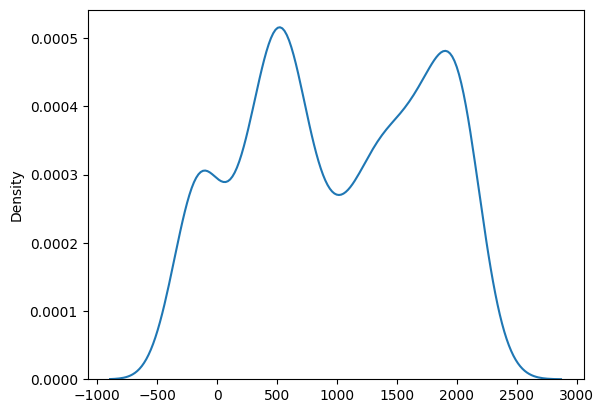

In [3]:
# data contains three dictionaries:
# - data['results'] is a symmetrical matrix containing all the match outcomes between two players
# - data['elo'] contains the estimated elo ratings from the results computed with a WLS regression
# - data['std'] contains the estimated standard deviations from the previous WLS regression

sns.kdeplot(data=data['elo'])

## Estimating ELO with a Linear regression

<Axes: ylabel='Density'>

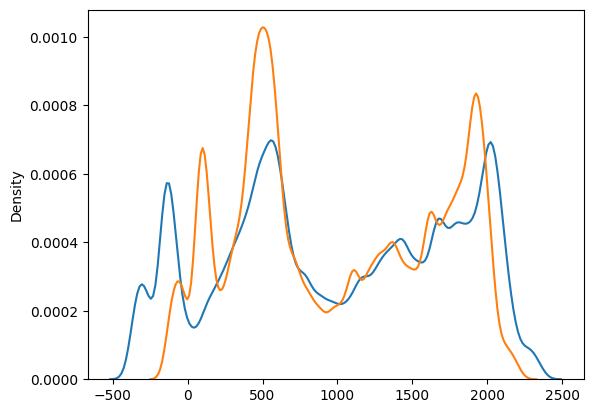

In [4]:
elos_ols = compute_elo(data['results'])
sns.kdeplot(data=data['elo'], bw_adjust=0.25)
sns.kdeplot(data=elos_ols, bw_adjust=0.25)

<Axes: ylabel='Density'>

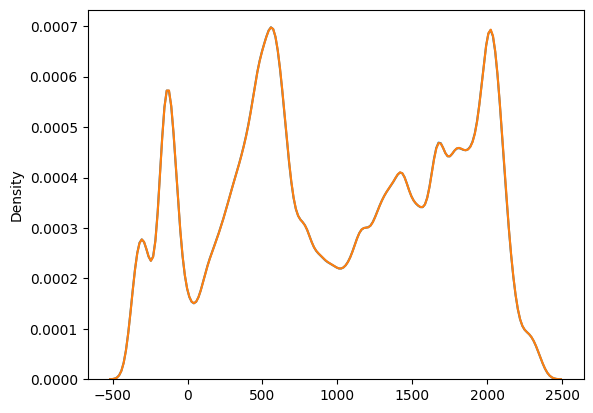

In [5]:
elos_wls, sds_wls = compute_elo(data['results'], wls=True)
# elos should be the same as data['elo']
sns.kdeplot(data=data['elo'], bw_adjust=0.25)
sns.kdeplot(data=elos_wls, bw_adjust=0.25)

## Plot Models

In [6]:
# Timing data was extracted from the aim server using `aim-export.py`
with open("../data-hours-['train', 'selfplay'].json", "r") as f:
    timing_data = json.load(f)

In [7]:
def make_range(config, model, offset=0):
    return [x+offset for x in range(config['start'], config['end'], config['step']) if f"{model}/{x:03}" in all_players]

# We group players coming from the same model run together

with open("../models_description.json", "r") as f:
    evr = json.load(f)

# ic = 0.95
# sigma = norm.ppf(1-(1-ic)/2)
sigma = 2

for model, config in evr.items():
    evr[model]['elo_ols'] = [
        elos_ols[f"{model}/{it:03}"]
        for it in make_range(config, model)
    ]
    evr[model]['elo_wls'] = [
        elos_wls[f"{model}/{it:03}"]
        for it in make_range(config, model)
    ]
    evr[model]['running_time'] = [
        train + selfplay
        for train, selfplay in zip(timing_data[model]['train'], timing_data[model]['selfplay'])
    ]
    evr[model]['elo_wls'] = [
        elos_wls[f"{model}/{it:03}"]
        for it in make_range(config, model)
    ]
    evr[model]['sd_wls'] = [
        sds_wls[f"{model}/{it:03}"]
        for it in make_range(config, model)
    ]
    evr[model]['ci_wls'] = sigma * np.array(evr[model]['sd_wls'])

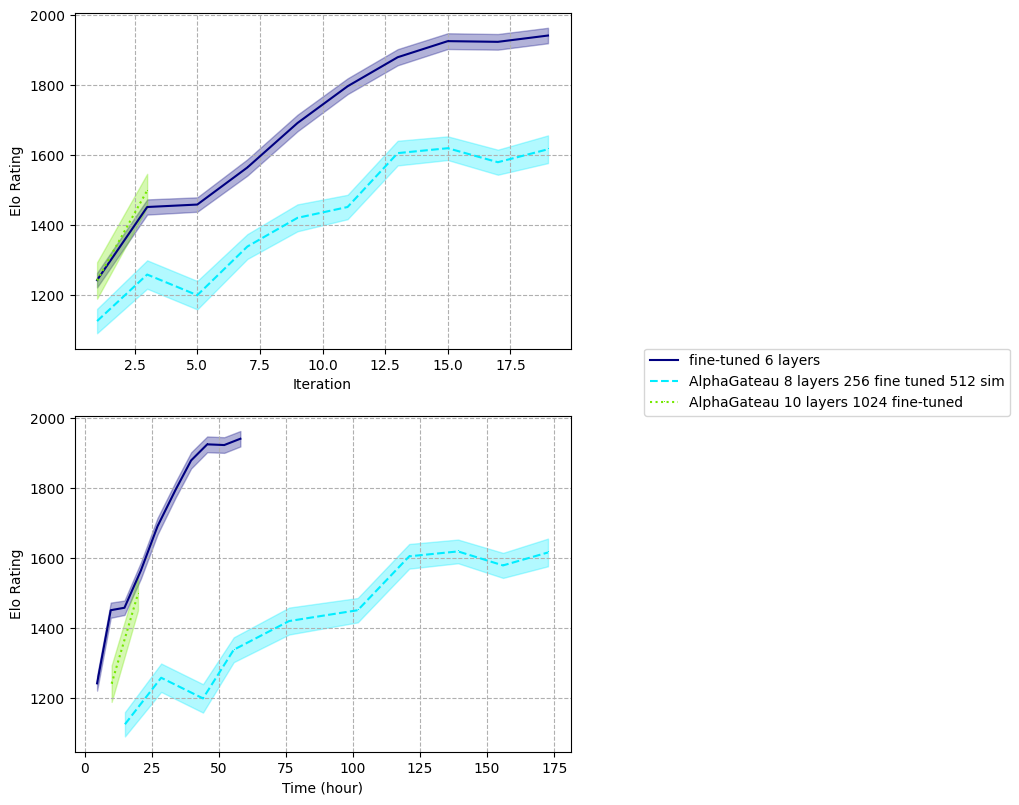

In [8]:
monochrome = (cycler('marker', [',', '.', '+']) * cycler('linestyle', ['-', '--', ':']))

def plot_all(models, use_running_time=False):
    n_plots = 2 if use_running_time else 1
    fig, axs = plt.subplots(n_plots, figsize=(6.4, n_plots * 4.8))
    if n_plots == 1:
        axs = [axs]
    for i, ax in enumerate(axs):
        ax.grid(True, linestyle='--')
        cmap = plt.get_cmap('gist_ncar', max(6, int(1.1*len(models))+1))
        ax.set_prop_cycle(monochrome)
        for j, model in enumerate(models):
            m_data = evr[model]
            X = make_range(m_data, model)
            if i == 1:
                X = [m_data['running_time'][x] for x in X]
            ax.plot(
                X,
                m_data['elo_wls'],
                label=m_data['label'],
                color=cmap(j)
            )
            ax.fill_between(
                X,
                m_data['elo_wls'] - m_data['ci_wls'],
                m_data['elo_wls'] + m_data['ci_wls'],
                alpha=0.3,
                color=cmap(j)
            )
        ax.set_xlabel('Time (hour)' if i == 1 else 'Iteration')
        ax.set_ylabel('Elo Rating')
    if use_running_time:
        axs[0].legend(loc='center right', bbox_to_anchor=(1.9, -0.1), prop={'size': 10}, ncol=1)
    else:
        axs[0].legend(loc='center right', bbox_to_anchor=(2.5, 0.5), prop={'size': 10}, ncol=2)

short = [model for model in evr if max(make_range(evr[model], model)) <= 50]
medium = [model for model in evr if 50 < max(make_range(evr[model], model)) <= 100]
long = [model for model in evr if 100 < max(make_range(evr[model], model))]
plot_all(short, use_running_time=True)

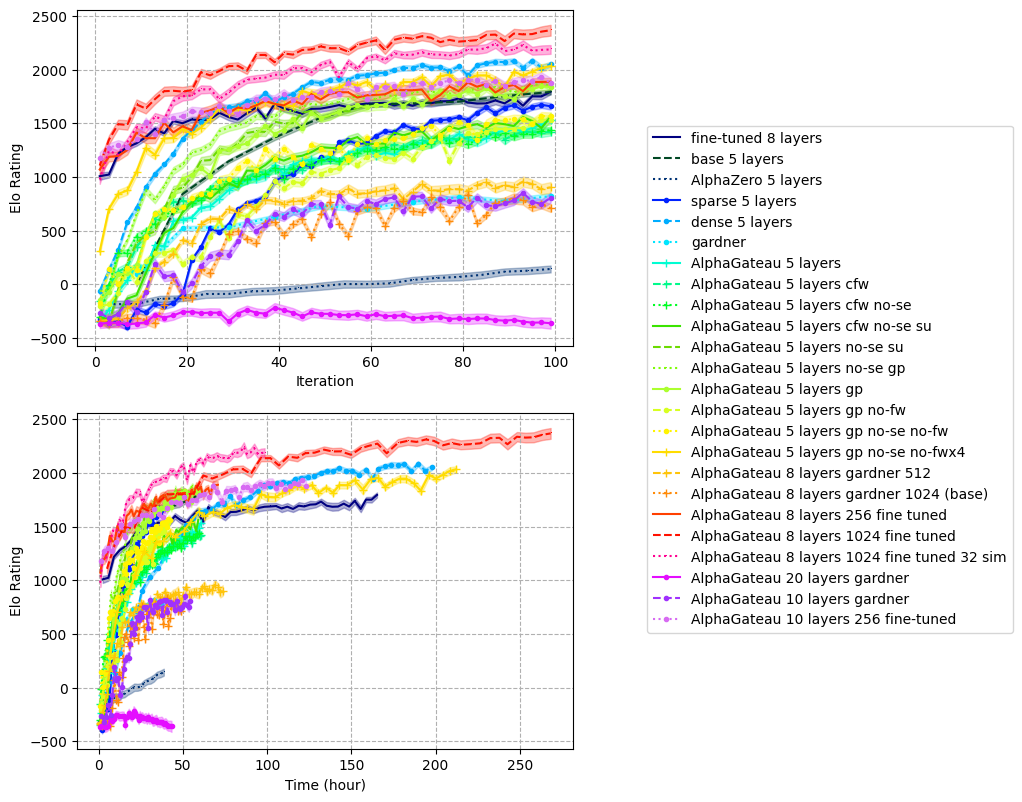

In [9]:
plot_all(medium, use_running_time=True)

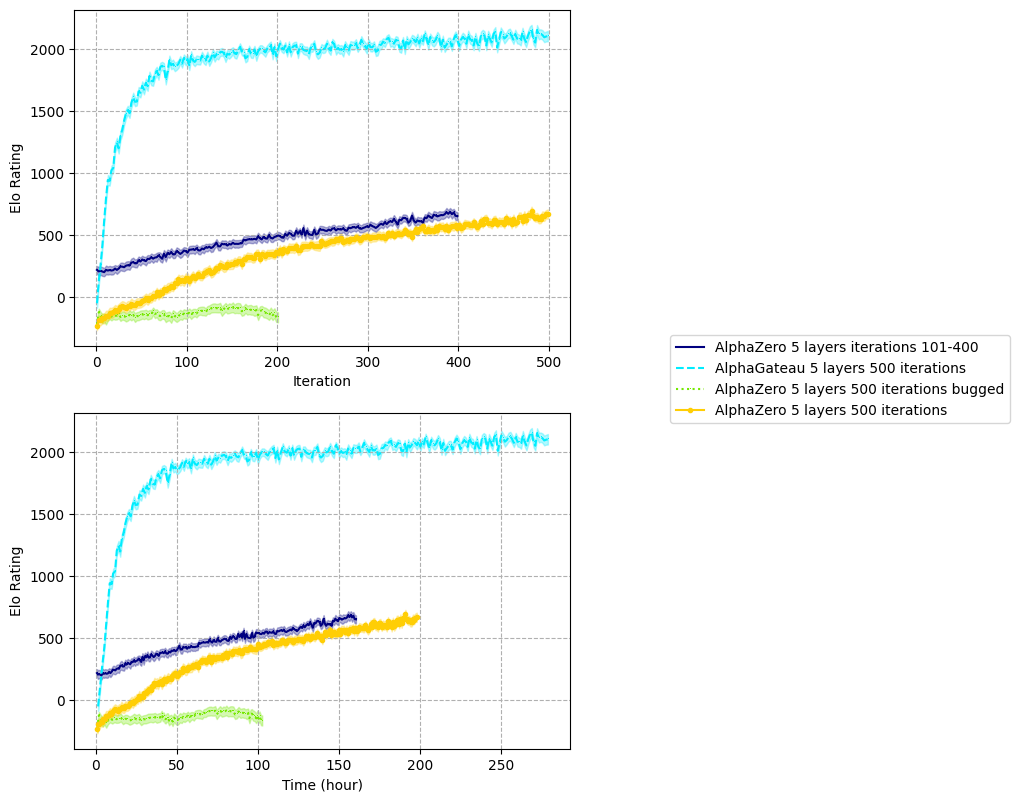

In [10]:
plot_all(long, use_running_time=True)

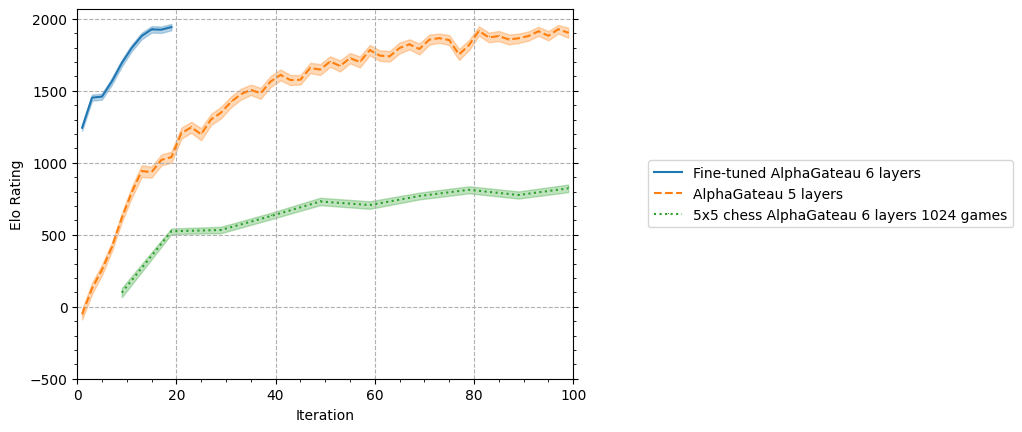

In [11]:
def find_model(name):
    for m in evr.keys():
        if evr[m]['label'] == name:
            return m

def print_elo_approx(model, it):
    print(evr[model]['elo_wls'][it], '±', evr[model]['ci_wls'][it])
    print(f"{evr[model]['elo_wls'][it]:.0f} ± {evr[model]['ci_wls'][it]:.0f}")

def clean_plot(
    model_names,
    labels,
    dm=False,
    legend_in=False,
    legend_loc='center right',
    offsets=None,
    maxi=2000,
    max_iter=None,
    use_running_time=False,
):
    cmap = plt.get_cmap("tab20")
    if offsets is None:
        offsets = [0] * len(model_names)
    fig, ax = plt.subplots()
    ax.set_prop_cycle(monochrome)
    range_min, range_max = 0, 10 if use_running_time else 100
    for i, (model_name, label) in enumerate(zip(model_names, labels)):
        if model_name == "":
            continue
        model = find_model(model_name)
        m_data = evr[model]
        x = make_range(m_data, model, offset=offsets[i])
        y = m_data['elo_wls']
        ym = m_data['elo_wls'] - m_data['ci_wls']
        yp = m_data['elo_wls'] + m_data['ci_wls']
        if use_running_time:
            factor = evr[model]['GPUS'] / 8
            x = [factor * evr[model]['running_time'][xx] for xx in x]
        if max_iter is not None:
            x = x[:max_iter]
            y = y[:max_iter]
            ym = ym[:max_iter]
            yp = yp[:max_iter]
        range_min = min(range_min, min(x))
        range_max = max(range_max, max(x))
        ax.plot(x, y, label=label, color=cmap(i) if dm else f"C{i}", markersize=5)
        ax.fill_between(
            x,
            ym,
            yp,
            alpha=0.3,
            color=cmap(i) if dm else f"C{i}"
        )
    range_min = int(range_min)
    range_max = int(range_max)
    pos = ax.get_position()
    ax.set_xlabel('Time (hour)' if use_running_time else 'Iteration')
    ax.set_ylabel('Elo Rating')
    plt.grid(True, linestyle='--')
    largestep = 20 if range_max - range_min <= 100 else 50
    smallstep = 5 if range_max - range_min <= 100 else 10
    min_segment = 10 if use_running_time else largestep
    k = (range_max - range_min + min_segment - 1) // min_segment
    range_max = range_min + k * min_segment
    ax.set_xticks(range(range_min,range_max+1,largestep), minor=False)
    ax.set_xticks(range(range_min,range_max+1,smallstep), minor=True)
    ax.set_yticks(range(-500,2001,500), minor=False)
    ax.set_yticks(range(-500,maxi+1,100), minor=True)
    ax.tick_params(right=True, which='both')
    ax.set_xlim(range_min, range_max)
    if legend_in:
        ax.legend()
    else:
        ax.legend(loc=legend_loc, bbox_to_anchor=(1.9, 0.5))
    return fig

fig = clean_plot([
    'fine-tuned 6 layers',
    'AlphaGateau 5 layers 500 iterations',
    'gardner'
], [
    'Fine-tuned AlphaGateau 6 layers',
    'AlphaGateau 5 layers',
    '5x5 chess AlphaGateau 6 layers 1024 games'
], max_iter=50)

## Article Main Results

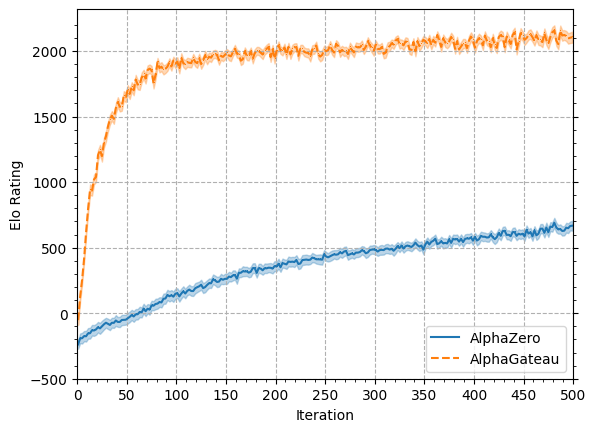

In [12]:
fig = clean_plot([
    'AlphaZero 5 layers 500 iterations',
    'AlphaGateau 5 layers 500 iterations',
], [
    'AlphaZero',
    'AlphaGateau',
], dm=False, maxi=2200, legend_in=True)
fig.savefig('../figures/exp1_new.pdf')

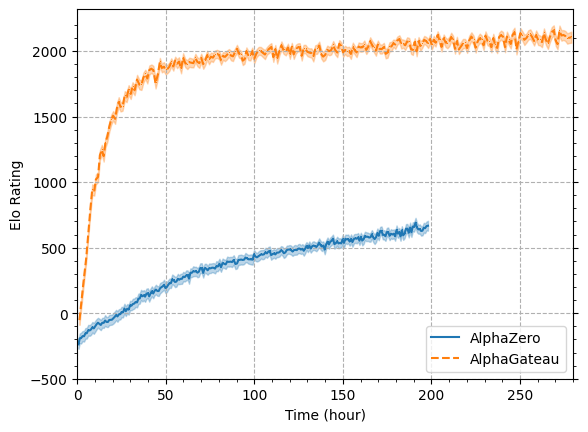

In [13]:
fig = clean_plot([
    'AlphaZero 5 layers 500 iterations',
    'AlphaGateau 5 layers 500 iterations',
], [
    'AlphaZero',
    'AlphaGateau',
], dm=False, maxi=2200, legend_in=True, use_running_time=True)
fig.savefig('../figures/exp1_flops.pdf')

In [14]:
# AlphaZero last ELO
print_elo_approx(find_model('AlphaZero 5 layers 500 iterations'), -1)

667 ± 37.80303493136446
667 ± 38


In [15]:
# AlphaGateau last ELO
print_elo_approx(find_model('AlphaGateau 5 layers 500 iterations'), -1)

2105 ± 42.45302493872797
2105 ± 42


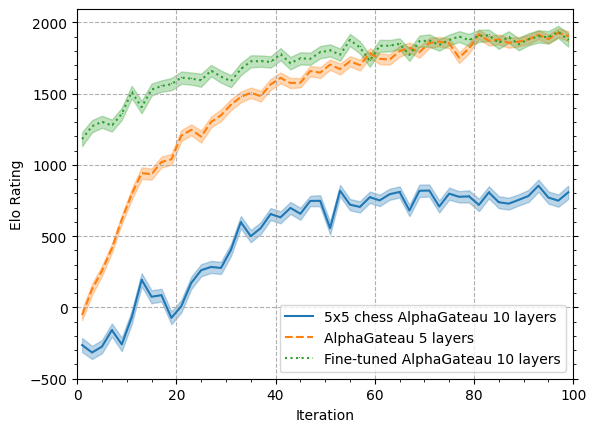

In [16]:
fig = clean_plot([
    'AlphaGateau 10 layers gardner',
    'AlphaGateau 5 layers 500 iterations',
    'AlphaGateau 10 layers 256 fine-tuned',
], [
    '5x5 chess AlphaGateau 10 layers',
    'AlphaGateau 5 layers',
    'Fine-tuned AlphaGateau 10 layers',
], max_iter=50, legend_in=True)
fig.savefig('../figures/exp2_new.pdf')

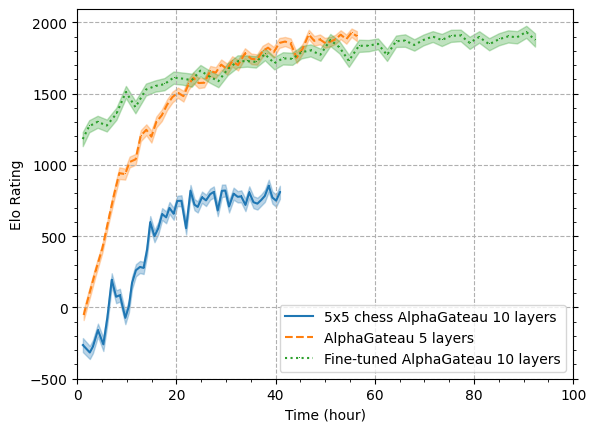

In [17]:
fig = clean_plot([
    'AlphaGateau 10 layers gardner',
    'AlphaGateau 5 layers 500 iterations',
    'AlphaGateau 10 layers 256 fine-tuned',
], [
    '5x5 chess AlphaGateau 10 layers',
    'AlphaGateau 5 layers',
    'Fine-tuned AlphaGateau 10 layers',
], legend_in=True, max_iter=50, use_running_time=True)
fig.savefig('../figures/exp2_flops.pdf')

In [18]:
# 5x5 training last ELO
print_elo_approx(find_model('AlphaGateau 10 layers gardner'), -1)

807 ± 46.38821219606233
807 ± 46


In [19]:
# 5x5 training fine-tuning first ELO
print_elo_approx(find_model('AlphaGateau 10 layers 256 fine-tuned'), 0)

1181 ± 49.63087259670942
1181 ± 50


In [20]:
# 5x5 training fine-tuning last ELO
print_elo_approx(find_model('AlphaGateau 10 layers 256 fine-tuned'), -1)

1876 ± 46.60914431184531
1876 ± 47


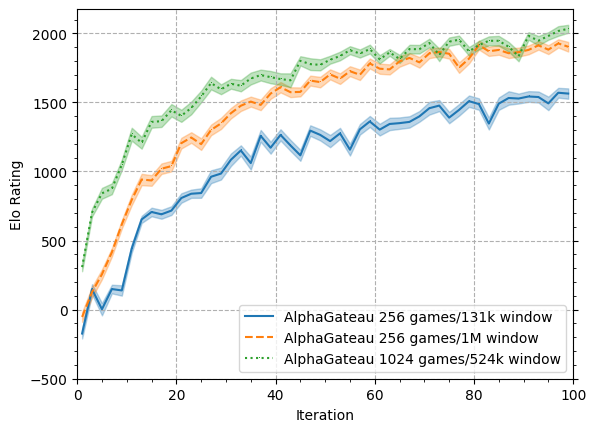

In [21]:
fig = clean_plot([
    'AlphaGateau 5 layers gp no-se no-fw',
    'AlphaGateau 5 layers 500 iterations',
    'AlphaGateau 5 layers gp no-se no-fwx4',
], [
    'AlphaGateau 256 games/131k window',
    'AlphaGateau 256 games/1M window',
    'AlphaGateau 1024 games/524k window',
], max_iter=50, maxi=2100, legend_in=True)
fig.savefig('../figures/exp3_new.pdf')

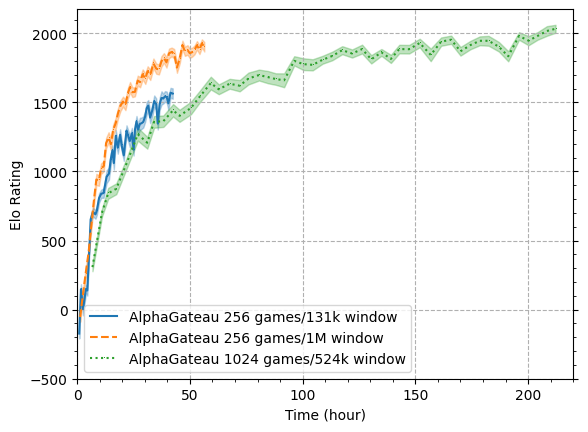

In [22]:
fig = clean_plot([
    'AlphaGateau 5 layers gp no-se no-fw',
    'AlphaGateau 5 layers 500 iterations',
    'AlphaGateau 5 layers gp no-se no-fwx4',
], [
    'AlphaGateau 256 games/131k window',
    'AlphaGateau 256 games/1M window',
    'AlphaGateau 1024 games/524k window',
], max_iter=50, maxi=2100, legend_in=True, use_running_time=True)
fig.savefig('../figures/exp3_flops.pdf')

# Other Plots

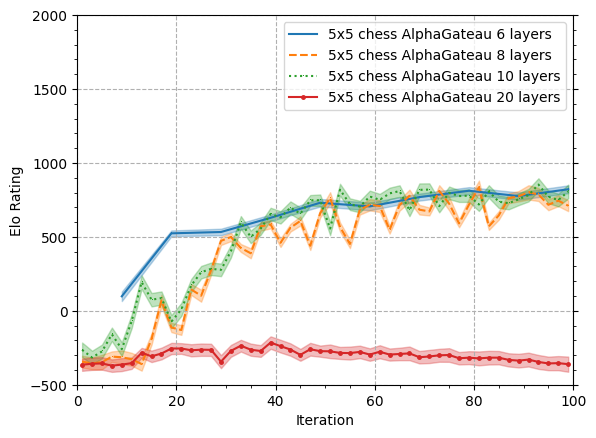

In [23]:
fig = clean_plot([
    'gardner',
    'AlphaGateau 8 layers gardner 1024 (base)',
    'AlphaGateau 10 layers gardner',
    'AlphaGateau 20 layers gardner',
], [
    '5x5 chess AlphaGateau 6 layers',
    '5x5 chess AlphaGateau 8 layers',
    '5x5 chess AlphaGateau 10 layers',
    '5x5 chess AlphaGateau 20 layers'
], legend_in=True)

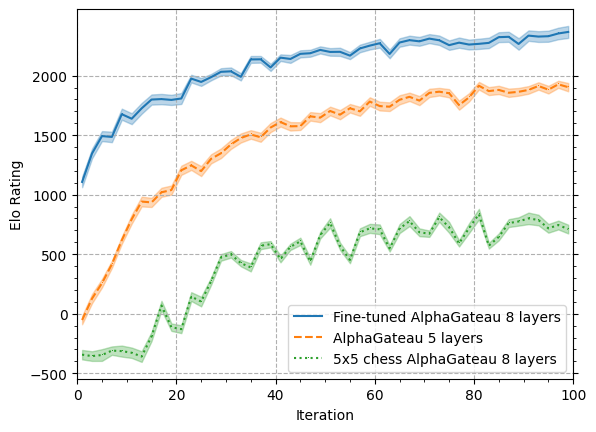

In [24]:
fig = clean_plot([
    'AlphaGateau 8 layers 1024 fine tuned',
    'AlphaGateau 5 layers 500 iterations',
    'AlphaGateau 8 layers gardner 1024 (base)',
], [
    'Fine-tuned AlphaGateau 8 layers',
    'AlphaGateau 5 layers',
    '5x5 chess AlphaGateau 8 layers'
], max_iter=50, legend_in=True)

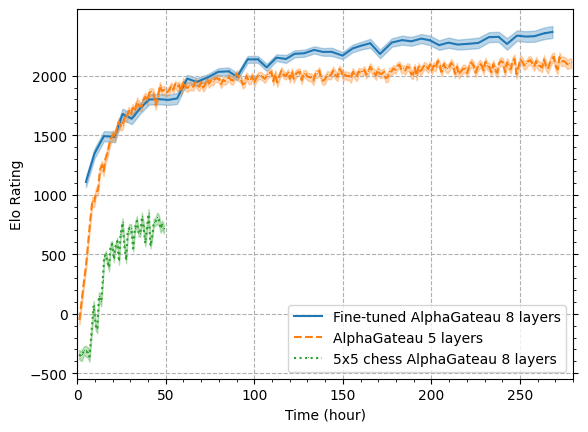

In [25]:
fig = clean_plot([
    'AlphaGateau 8 layers 1024 fine tuned',
    'AlphaGateau 5 layers 500 iterations',
    'AlphaGateau 8 layers gardner 1024 (base)',
], [
    'Fine-tuned AlphaGateau 8 layers',
    'AlphaGateau 5 layers',
    '5x5 chess AlphaGateau 8 layers'
], legend_in=True, use_running_time=True)
fig.savefig('../figures/exp2_alt.pdf')

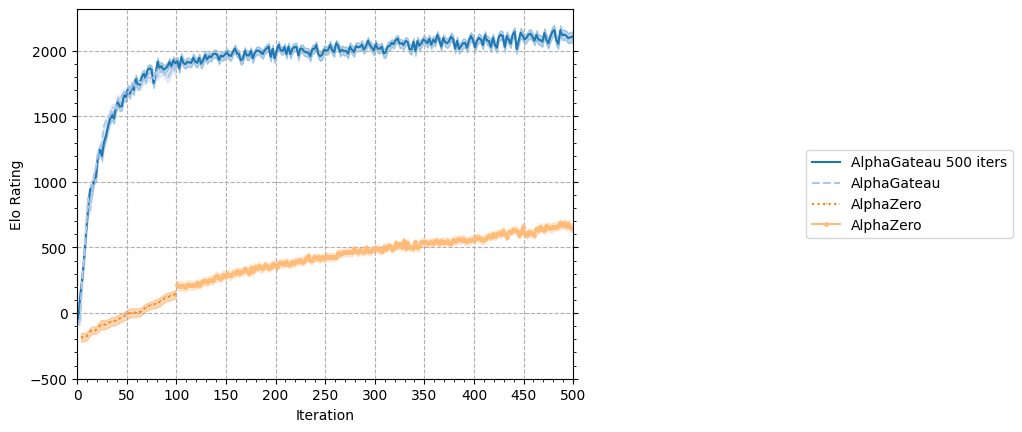

In [26]:
fig = clean_plot([
    'AlphaGateau 5 layers 500 iterations',
    'AlphaGateau 5 layers no-se gp',
    'AlphaZero 5 layers',
    'AlphaZero 5 layers iterations 101-400',
], [
    'AlphaGateau 500 iters',
    'AlphaGateau',
    'AlphaZero',
    'AlphaZero',
], dm=True, offsets=[
    0,
    0,
    0,
    100,
])

Text(0.5, 1.0, 'Standard Errors')

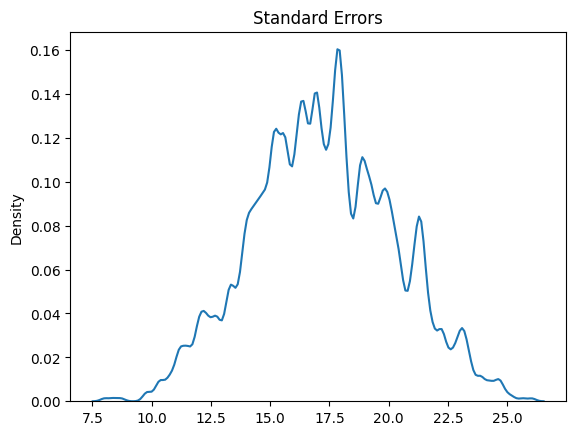

In [27]:
sns.kdeplot(data=sds_wls, bw_adjust=0.25)
plt.title("Standard Errors")

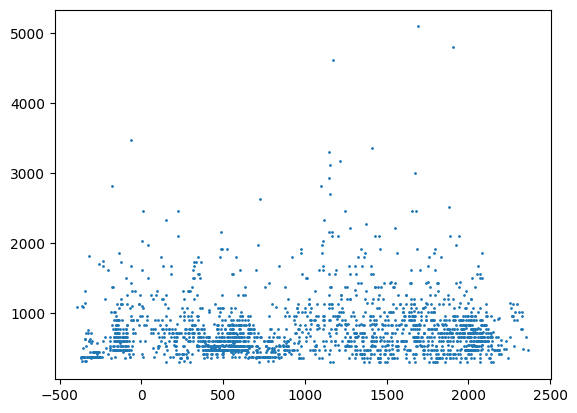

In [28]:
players = list(data['results'].keys())
n_matches = [sum(map(sum, data['results'][player].values())) for player in players]
plt.scatter(data['elo'].values(), n_matches, s=1)

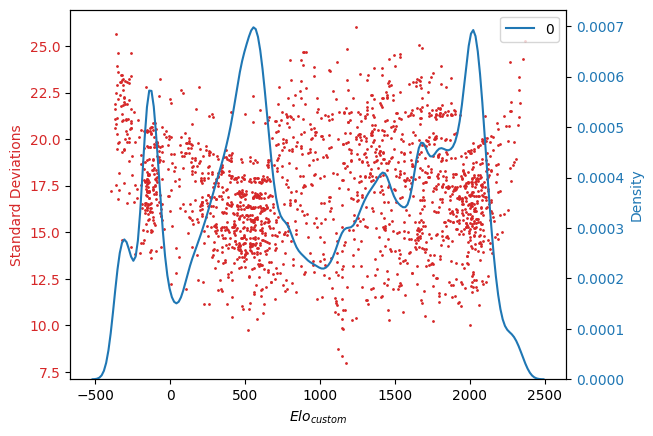

In [29]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("$Elo_{custom}$")
ax1.set_ylabel("Standard Deviations", color=color)
ax1.scatter(data['elo'].values(), data['std'].values(), s=1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel("Density", color=color)
sns.kdeplot(data=data['elo'].values(), label='WLS', bw_adjust=0.25, ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.savefig("../figures/elo distrib.pdf")

## Matching Method Evaluation

To evaluate our models, we make them play around 60 games around the player with closest Elo, then recompute all ratings using WLS. We then repeat this process a total of 5 times. To make sure that this method is sound, we plot how the estimated Elo rating evolve for one model for each game we add to the dataset, in the rough order they were played in (all the games played in a match between two players are played simultaneously, so we assign a random order between them)

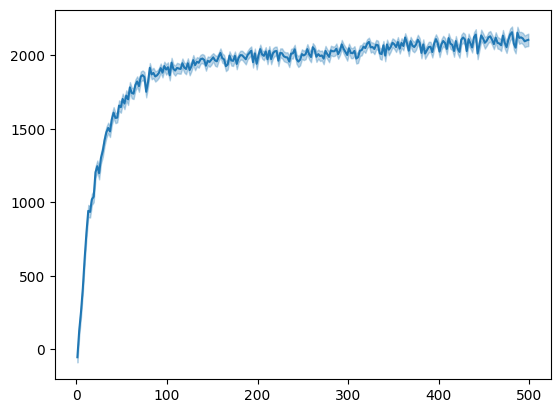

In [30]:
model = find_model('AlphaGateau 5 layers 500 iterations')

cmap = plt.get_cmap('tab10')
i=0
fig, ax = plt.subplots()
ax.plot(make_range(evr[model], model), evr[model]['elo_wls'], color=cmap(i))
ax.fill_between(
    make_range(evr[model], model),
    evr[model]['elo_wls'] - evr[model]['ci_wls'],
    evr[model]['elo_wls'] + evr[model]['ci_wls'],
    alpha=0.3,
    color=cmap(i)
)

# ==========

In [31]:
%%time
for i in range(1, 2):
    sparse_data = compute_elo(data['results'], wls=True, partial_model=model, partial_n_games=i)

CPU times: user 1min 31s, sys: 39.8 s, total: 2min 11s
Wall time: 6.99 s


In [32]:
%%time
for i in range(1, 2):
    sparse_data = compute_elo(data['results'], wls=False, partial_model=model, partial_n_games=i)

CPU times: user 17.2 s, sys: 15.8 s, total: 33 s
Wall time: 1.85 s


CPU times: user 1min 32s, sys: 36.8 s, total: 2min 9s
Wall time: 6.78 s


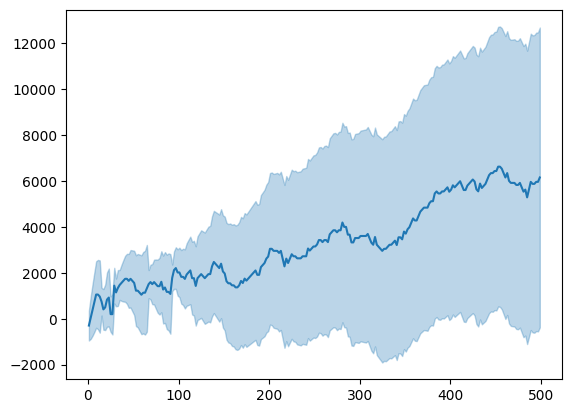

In [33]:
%%time
plot_data = {}

def partial_plot(model, n_games=1, wls=True):
    if model not in plot_data:
        plot_data[model] = {}
    if n_games not in plot_data[model]:
        part_elo, part_sd = compute_elo(
            data['results'],
            wls=wls,
            std=True,
            partial_model=model,
            partial_n_games=n_games,
        )
        model_elos = [
            part_elo[f"{model}/{it:03}"]
            for it in make_range(evr[model], model)
        ]
        model_sds = [
            part_sd[f"{model}/{it:03}"]
            for it in make_range(evr[model], model)
        ]
        part_ci = sigma * np.array(model_sds)
        plot_data[model][n_games] = model_elos, part_ci

    fig, ax = plt.subplots()
    ax.plot(make_range(evr[model], model), plot_data[model][n_games][0], color=cmap(0))
    ax.fill_between(
        make_range(evr[model], model),
        plot_data[model][n_games][0] - plot_data[model][n_games][1],
        plot_data[model][n_games][0] + plot_data[model][n_games][1],
        alpha=0.3,
        color=cmap(0)
    )

partial_plot(model, n_games=3)
alphagateau = None

In [34]:
%%time
%matplotlib widget
from ipywidgets import *
from matplotlib.animation import FuncAnimation
from IPython import display

if alphagateau is not None: # code disabling this cell if the previous cell wasn't executed
    rge = {
        alphagateau: make_range(evr[alphagateau], alphagateau),
        alphazero: make_range(evr[alphazero], alphazero)
    }
    
    dpi = 96
    fig = plt.figure(figsize=(1920/dpi, 1080/dpi), dpi=dpi)
    
    ax = fig.add_subplot()
    
    lines, con_int = {}, {}
    for i, m in enumerate([alphagateau, alphazero]):
        ax.plot(rge[m], plot_data[m][1080][0], '--', color=cmap(14), alpha=0.5)
        ax.fill_between(
            rge[m],
            plot_data[m][1080][0] - plot_data[m][1080][1],
            plot_data[m][1080][0] + plot_data[m][1080][1],
            alpha=0.15,
            color=cmap(14)
        )
        lines[m], = ax.plot(rge[m], plot_data[m][1][0], color=cmap(2*i))
        con_int[m] = ax.fill_between(
            rge[m],
            plot_data[m][1][0] - plot_data[m][1][1],
            plot_data[m][1][0] + plot_data[m][1][1],
            alpha=0.3,
            color=cmap(2*i)
        )
    ax.set_xlabel('Iteration')
    ax.set_ylabel('ELO Rating')
    ax.set_title(f"{alphagateau} and {alphazero} with 1 game")
    ax.set_ylim(-2000, 10000)
    
    gen_gif = True
    n_frames = 1080
    
    def update(n_games=1):
        global con_int
        if gen_gif:
            n_games = (n_games ** 2 // n_frames) + 1
        for i, m in enumerate([alphagateau, alphazero]):
            if n_games not in plot_data[m]:
                part_elo, part_sd = compute_elo(
                    data['results'],
                    wls=True,
                    std=True,
                    partial_model=m,
                    partial_n_games=n_games,
                )
                model_elos = [
                    part_elo[f"{m}/{it:03}"]
                    for it in make_range(evr[m], m)
                ]
                model_sds = [
                    part_sd[f"{m}/{it:03}"]
                    for it in make_range(evr[m], m)
                ]
                part_ci = sigma * np.array(model_sds)
                plot_data[m][n_games] = model_elos, part_ci
            lines[m].set_ydata(plot_data[m][n_games][0])
            con_int[m].remove()
            con_int[m] = ax.fill_between(
                rge[m],
                plot_data[m][n_games][0] - plot_data[m][n_games][1],
                plot_data[m][n_games][0] + plot_data[m][n_games][1],
                alpha=0.3,
                color=cmap(2*i)
            )
        ax.set_title(f"{alphagateau} and {alphazero} with {n_games} game{'s' if n_games > 1 else ''}")
        if not gen_gif:
            fig.canvas.draw()

    if gen_gif:
        anim_created = FuncAnimation(fig, update, frames=n_frames, interval=25)
        
        video = anim_created.to_html5_video()
        html = display.HTML(video)
        display.display(html)
    
        plt.close()
    else:
        interact(update, n_games=(1,1000,1));

CPU times: user 3.9 ms, sys: 6.94 ms, total: 10.8 ms
Wall time: 3.71 ms


In [35]:
best_model = None
best_elo = -1
for model in evr:
    cur_elo = max(evr[model]['elo_wls'])
    if cur_elo > best_elo:
        best_elo = cur_elo
        best_model = model
best_model, best_elo, evr[model]['label']

('chess_2024-07-02:15h33', 2367, 'AlphaGateau 10 layers 256 fine-tuned')